# Hypercube in N-dimension

In [4]:
import os
import sys
import scipy
import numpy as np
import pandas as pd
from tabulate import tabulate

from colorcet import palette
import datashader as ds
import datashader.colors as dc
import datashader.utils as utils
from datashader import transfer_functions as tf

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

In [5]:
import itertools as it

### Just some `matplotlib` and `seaborn` parameter tuning

In [6]:
axistitlesize = 26
axisticksize = 23
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

### Simulation hyperparameters

In [7]:
D = 4

## 0. Auxiliary functions

In [8]:
def E_mn(m, n):
    """
    Returns the hypercube element `E_mn`.
    
    Parameters:
    -----------
    m : int
        The m-dimensional sub-hypercube.
    n : int
        The n-dimensional hypercube.
    """
    return int(2**(n-m) * scipy.special.binom(n, m))

## 1. Find vertices of the N-dimensional hypercube

Consider a hypercube where the length of edges are 1 unit and the edges as parallel to the coordinate axis. Let us also place an arbitrary vertex to the origin $\left( 0,0 \right)$. In this scenario, the position vectors $\vec{r}$ of the vertices are either unit vectors or linear combination of unit vectors with coefficients all equal to $1$. The coordinates of the vertices for the 3-cube can be seen on this figure:

<center><img src="./images/cube_png.png" width="400" /></center>

Observing the coordinate vectors one can notice, that the unit vectors are just individual rows/columns of the identity matrix, while other position vectors of vertices are the possible combinations of them.

In [9]:
# Unit vectors in each cardinal direction
# These are only rows/columns of the D x D identity matrix
unit_vec = np.eye(D)

print('The {}-dimensional Identity matrix:'.format(D))
print(unit_vec)
print()
print('Unit vectors are equivalent to the rows of this matrix:')
print(tabulate(zip(range(unit_vec.shape[0]), unit_vec),
               headers=['Index of\nunit vector', 'Unit vector'],
               tablefmt='pretty'))

The 4-dimensional Identity matrix:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Unit vectors are equivalent to the rows of this matrix:
+-------------+---------------+
|  Index of   |  Unit vector  |
| unit vector |               |
+-------------+---------------+
|      0      | [1. 0. 0. 0.] |
|      1      | [0. 1. 0. 0.] |
|      2      | [0. 0. 1. 0.] |
|      3      | [0. 0. 0. 1.] |
+-------------+---------------+


In [10]:
# Vertices of the hypercube
# These are identic to the set of all combinations of the unit vectors
## 1. Get all combinations first
tmp = []
for i in range(1, D+1):
    tmp.append(list(it.combinations(unit_vec, i)))

## 2. Calculate the vertice coordinates by summing all corresponding
##    unit vector selections
vertices = np.zeros((E_mn(m=0, n=D), D))
i = 1
for p in tmp:
    for sp in p:
        vertices[i] = np.sum(sp, axis=0)
        i += 1

## Vertices normed around zero
vertices_norm = (vertices - 0.5)#*2

In [11]:
print('Vertices (m=0, n={0}) of the {0}-dimensional hypercube:'.format(D))
print(tabulate(zip(range(vertices.shape[0]), vertices),
               headers=['Index of\nVertex', 'Position vector'],
               tablefmt='pretty'))

Vertices (m=0, n=4) of the 4-dimensional hypercube:
+----------+-----------------+
| Index of | Position vector |
|  Vertex  |                 |
+----------+-----------------+
|    0     |  [0. 0. 0. 0.]  |
|    1     |  [1. 0. 0. 0.]  |
|    2     |  [0. 1. 0. 0.]  |
|    3     |  [0. 0. 1. 0.]  |
|    4     |  [0. 0. 0. 1.]  |
|    5     |  [1. 1. 0. 0.]  |
|    6     |  [1. 0. 1. 0.]  |
|    7     |  [1. 0. 0. 1.]  |
|    8     |  [0. 1. 1. 0.]  |
|    9     |  [0. 1. 0. 1.]  |
|    10    |  [0. 0. 1. 1.]  |
|    11    |  [1. 1. 1. 0.]  |
|    12    |  [1. 1. 0. 1.]  |
|    13    |  [1. 0. 1. 1.]  |
|    14    |  [0. 1. 1. 1.]  |
|    15    |  [1. 1. 1. 1.]  |
+----------+-----------------+


## 2. Find edges

### 2.1. Find vertices $L=1$ step away (they're already edges basically, but doubled)

In [12]:
edges_1 = np.zeros((E_mn(m=0, n=D), D), dtype=int)

for i in range(vertices.shape[0]):
    e = 0
    for j in range(vertices.shape[0]):
        if i == j:
            continue
        if np.sum(np.abs(vertices[i]-vertices[j])) == 1:
            edges_1[i][e] = j
            e += 1

In [13]:
print('Edges (m=1, n={0}) of the {0}-dimensional hypercube:'.format(D))
print(tabulate(zip(range(edges_1.shape[0]), edges_1),
               headers=['Index of\nVertex', 'Indeces of vertices\nat 1 Hammond distance'],
               tablefmt='pretty'))

Edges (m=1, n=4) of the 4-dimensional hypercube:
+----------+-----------------------+
| Index of |  Indeces of vertices  |
|  Vertex  | at 1 Hammond distance |
+----------+-----------------------+
|    0     |       [1 2 3 4]       |
|    1     |       [0 5 6 7]       |
|    2     |       [0 5 8 9]       |
|    3     |     [ 0  6  8 10]     |
|    4     |     [ 0  7  9 10]     |
|    5     |     [ 1  2 11 12]     |
|    6     |     [ 1  3 11 13]     |
|    7     |     [ 1  4 12 13]     |
|    8     |     [ 2  3 11 14]     |
|    9     |     [ 2  4 12 14]     |
|    10    |     [ 3  4 13 14]     |
|    11    |     [ 5  6  8 15]     |
|    12    |     [ 5  7  9 15]     |
|    13    |     [ 6  7 10 15]     |
|    14    |     [ 8  9 10 15]     |
|    15    |     [11 12 13 14]     |
+----------+-----------------------+


### 2.2. Find (real) edges ($m=1$)

In [14]:
m = 1
edges = np.zeros((E_mn(m=m, n=D), 2**m), dtype=int)

e = 0
for i, e0 in enumerate(edges_1):
    for i2 in e0:
        edge = np.array(sorted([i, i2]))
        if (edges == edge).all(axis=1).any():
            continue
        else:
            edges[e] = edge
            e += 1

In [15]:
print('Edges (m=1, n={0}) of the {0}-dimensional hypercube:'.format(D))
print(tabulate(zip(range(edges.shape[0]), edges),
               headers=['Index of\nEdge', 'Indeces of vertices\nat endpoints'],
               tablefmt='pretty'))

Edges (m=1, n=4) of the 4-dimensional hypercube:
+----------+---------------------+
| Index of | Indeces of vertices |
|   Edge   |    at endpoints     |
+----------+---------------------+
|    0     |        [0 1]        |
|    1     |        [0 2]        |
|    2     |        [0 3]        |
|    3     |        [0 4]        |
|    4     |        [1 5]        |
|    5     |        [1 6]        |
|    6     |        [1 7]        |
|    7     |        [2 5]        |
|    8     |        [2 8]        |
|    9     |        [2 9]        |
|    10    |        [3 6]        |
|    11    |        [3 8]        |
|    12    |       [ 3 10]       |
|    13    |        [4 7]        |
|    14    |        [4 9]        |
|    15    |       [ 4 10]       |
|    16    |       [ 5 11]       |
|    17    |       [ 5 12]       |
|    18    |       [ 6 11]       |
|    19    |       [ 6 13]       |
|    20    |       [ 7 12]       |
|    21    |       [ 7 13]       |
|    22    |       [ 8 11]       |
|    2

## 3. Find faces

### 3.1. Find vertices $L=2$ step away

In [16]:
m = 0
edges_2 = np.zeros((E_mn(m=m, n=D), D*(D-1)//2), dtype=int)

for i in range(vertices.shape[0]):
    e = 0
    for j in range(vertices.shape[0]):
        if i == j:
            continue
        if np.sum(np.abs(vertices[i]-vertices[j])) == 2:
            edges_2[i][e] = j
            e += 1 

In [17]:
print('Paths (m=1, n={0}) in the {0}-dimensional hypercube:'.format(D))
print(tabulate(zip(range(edges_2.shape[0]), edges_2),
               headers=['Index of\nVertex', 'Indeces of vertices\nat 2 Hammond distance'],
               tablefmt='pretty'))

Paths (m=1, n=4) in the 4-dimensional hypercube:
+----------+-----------------------+
| Index of |  Indeces of vertices  |
|  Vertex  | at 2 Hammond distance |
+----------+-----------------------+
|    0     |  [ 5  6  7  8  9 10]  |
|    1     |  [ 2  3  4 11 12 13]  |
|    2     |  [ 1  3  4 11 12 14]  |
|    3     |  [ 1  2  4 11 13 14]  |
|    4     |  [ 1  2  3 12 13 14]  |
|    5     |  [ 0  6  7  8  9 15]  |
|    6     |  [ 0  5  7  8 10 15]  |
|    7     |  [ 0  5  6  9 10 15]  |
|    8     |  [ 0  5  6  9 10 15]  |
|    9     |  [ 0  5  7  8 10 15]  |
|    10    |  [ 0  6  7  8  9 15]  |
|    11    |  [ 1  2  3 12 13 14]  |
|    12    |  [ 1  2  4 11 13 14]  |
|    13    |  [ 1  3  4 11 12 14]  |
|    14    |  [ 2  3  4 11 12 13]  |
|    15    |  [ 5  6  7  8  9 10]  |
+----------+-----------------------+


### 3.2. Find intermitting vertices between vertex 0. and 2. and collect faces ($m=2$)

In [18]:
m = 2
faces = np.zeros((E_mn(m=m, n=D), 2**m), dtype=int)

f = 0
for i, e in enumerate(edges_2):
    for i2 in e:
        e0 = set(edges_1[i])
        e2 = set(edges_1[i2])
        z = np.array(sorted([i, i2] + list(e0.intersection(e2))))
        if (faces == z).all(axis=1).any():
            continue
        else:
            faces[f] = z
            f += 1

In [19]:
print('Faces (m=2, n={0}) of the {0}-dimensional hypercube:'.format(D))
print(tabulate(zip(range(faces.shape[0]), faces),
               headers=['Index of\nFace', 'Indeces of vertices\nat corners'],
               tablefmt='pretty'))

Faces (m=2, n=4) of the 4-dimensional hypercube:
+----------+---------------------+
| Index of | Indeces of vertices |
|   Face   |     at corners      |
+----------+---------------------+
|    0     |      [0 1 2 5]      |
|    1     |      [0 1 3 6]      |
|    2     |      [0 1 4 7]      |
|    3     |      [0 2 3 8]      |
|    4     |      [0 2 4 9]      |
|    5     |    [ 0  3  4 10]    |
|    6     |    [ 1  5  6 11]    |
|    7     |    [ 1  5  7 12]    |
|    8     |    [ 1  6  7 13]    |
|    9     |    [ 2  5  8 11]    |
|    10    |    [ 2  5  9 12]    |
|    11    |    [ 2  8  9 14]    |
|    12    |    [ 3  6  8 11]    |
|    13    |    [ 3  6 10 13]    |
|    14    |    [ 3  8 10 14]    |
|    15    |    [ 4  7  9 12]    |
|    16    |    [ 4  7 10 13]    |
|    17    |    [ 4  9 10 14]    |
|    18    |    [ 5 11 12 15]    |
|    19    |    [ 6 11 13 15]    |
|    20    |    [ 7 12 13 15]    |
|    21    |    [ 8 11 14 15]    |
|    22    |    [ 9 12 14 15]    |
|    2

## 4. Rotation of a 4D hypercube

### 4.1. Define a projection $P$, where $P\ :\ \mathbb{R}^{4} \mapsto \mathbb{R}^{3}$

As the answer discusses it [on this link](https://math.stackexchange.com/questions/723820/tesseract-projection-into-3d/723879#723879), the visualization of the 4D tesseract in the 3D space can be done by placing a lightsource at the location above the tesseract into eg. the point $\boldsymbol{c} = \left( 0,0,0,h \right)$. After that we map each point $\boldsymbol{x} = \left( x, y, z, w \right)$ with $w \neq h$ to its "shadow", the intersection of $\mathbb{R}^{3} \times \left\{ 0 \right\}$ with the ray from $\boldsymbol{c}$ through $\boldsymbol{x}$: 

$$
P \left( x, y, z, w \right)
=
\frac{h}{h - w}
\begin{pmatrix}
    x \\ y \\ z
\end{pmatrix}
$$

We will get the final image of the tesseract in 4D by applying the projection

$$
P \boldsymbol{v} \left( x, y, z, w \right)
=
\boldsymbol{v}_{\text{proj}} \left( x, y, z \right)
$$

In [20]:
def proj_4d(v, h):
    """
    Projects 4D coordinates to 3D from a given view distance.
    
    God bless Andrew D. Hwang:
    https://math.stackexchange.com/questions/723820/tesseract-projection-into-3d/723879#723879
    
    Parameters:
    -----------
    v : array-like
        4D array of coodinates
        
    h : distance of viewpoint from the center
    """
    
    return v[:,:3] * (h / (h - v[:,3]))[:, np.newaxis]

### 4.2. Rotation matrix in Euclidean metric

Rotations discussed and implemented here are exclusively rotations around planes spanned by basis vectors $\left( x,y,z,w \right)$ in case of 4D. The rotation matrix in 2D can be written in the form

$$
R_{2D}
=
\begin{pmatrix}
    \cos \left( \varphi \right)  & \sin \left( \varphi \right) \\
    -\sin \left( \varphi \right) & \cos \left( \varphi \right)
\end{pmatrix}
$$

Rotation matrices in higher dimensions always contain these same elements (except for the sign in case of the two $\sin$ functions reversed) if the rotation is around basis vectors or hyperplanes spanned by basis vectors. In 4D there are exactly $6$ possible rotations given this constraint, which are the following:

$$
R_{zw}
=
\begin{pmatrix}
    \cos \left( \varphi \right)  & -\sin \left( \varphi \right) & 0 & 0 \\
    \sin \left( \varphi \right)  & \cos \left( \varphi \right)  & 0 & 0 \\
    0                            & 0                            & 1 & 0 \\
    0                            & 0                            & 0 & 1 \\
\end{pmatrix}
\quad
;
\quad
R_{yw}
=
\begin{pmatrix}
    \cos \left( \varphi \right)  & 0 & -\sin \left( \varphi \right) & 0 \\
    0                            & 1 & 0                            & 0 \\
    \sin \left( \varphi \right)  & 0 & \cos \left( \varphi \right)  & 0 \\
    0                            & 0 & 0                            & 1 \\
\end{pmatrix}
\quad
;
\quad
R_{yz}
=
\begin{pmatrix}
    \cos \left( \varphi \right)  & 0 & 0 & -\sin \left( \varphi \right) \\
    0                            & 1 & 0 & 0                            \\
    0                            & 0 & 1 & 0                            \\
    \sin \left( \varphi \right)  & 0 & 0 & \cos \left( \varphi \right)  \\
\end{pmatrix}
$$

$$
R_{xw}
=
\begin{pmatrix}
    1 & 0                            & 0                            & 0 \\
    0 & \cos \left( \varphi \right)  & -\sin \left( \varphi \right) & 0 \\
    0 & \sin \left( \varphi \right)  & \cos \left( \varphi \right)  & 0 \\
    0 & 0                            & 0                            & 1 \\
\end{pmatrix}
\quad
;
\quad
R_{xz}
=
\begin{pmatrix}
    1 & 0                            & 0                           & 0  \\
    0 & \cos \left( \varphi \right)  & 0 & -\sin \left( \varphi \right) \\
    0 & 0                            & 1                           & 0  \\
    0 & \sin \left( \varphi \right)  & 0 & \cos \left( \varphi \right)  \\
\end{pmatrix}
\quad
;
\quad
R_{xy}
=
\begin{pmatrix}
    1 & 0 & 0                            & 0                            \\
    0 & 1 & 0                            & 0                            \\
    0 & 0 & \cos \left( \varphi \right)  & -\sin \left( \varphi \right) \\
    0 & 0 & \sin \left( \varphi \right)  & \cos \left( \varphi \right)  \\
\end{pmatrix}
$$

The rotation operator can be applied to the original vector to rotate it accordingly:

$$
R \boldsymbol{v} \left( x,y,z,w \right)
=
\boldsymbol{v}_{\text{rot}} \left( x,y,z,w \right)
$$

In [21]:
def rot_4d(v, t, p):
    """
    Rotate 4D coordinates around a hyperplane.
    
    Parameters:
    -----------
    v : array-like of shape (N, D)
        The set of coordinates to rotate.
    t : float
        Angle of rotation around the choosen hyperplane
    p : int between 1 - 6
        Index to choose the hyperplane of rotation:
        - 1 : rotate around z,w axis
        - 2 : rotate around y,w axis
        - 3 : rotate around y,z axis
        - 4 : rotate around x,w axis
        - 5 : rotate around x,z axis
        - 6 : rotate around x,y axis
    """
    R_p = np.array((
        (np.cos(np.deg2rad(t)), -np.sin(np.deg2rad(t))),
        (np.sin(np.deg2rad(t)), np.cos(np.deg2rad(t)))
    ))
    I = np.eye(v.shape[1])
    
    si = [
        tuple([[[0], [1]], [0,1]]),  # Rotate around z,w
        tuple([[[0], [2]], [0,2]]),  # Rotate around y,w
        tuple([[[0], [3]], [0,3]]),  # Rotate around y,z
        tuple([[[1], [2]], [1,2]]),  # Rotate around x,w
        tuple([[[1], [3]], [1,3]]),  # Rotate around x,z
        tuple([[[2], [3]], [2,3]]),  # Rotate around x,y
    ]
    
    R = I.copy()
    R[si[p-1]] = R_p
    
    return (R @ v.T).T

In [22]:
def plot_4d(v, edges, fname=None, save=True):
    """
    Plots the vertices and edges of the 3D projection of a 4D hypercube.
    """
    plt.ioff()
    fig, axes = plt.subplots(figsize=(12,12),
                         facecolor='black',
                         subplot_kw={
                             'projection' : '3d',
                             'facecolor' : 'black'
                         })
    axes.axis('off')
    axes.set_xlim(-1,1)
    axes.set_ylim(-1,1)
    axes.set_zlim(-1,1)

    axes.scatter(v[:,0],
                 v[:,1],
                 v[:,2],
                 color=cm.PuBu_r(0.85), s=15**2)

    for e in edges:
        axes.plot([ v[e[0]][0], v[e[1]][0] ],
                  [ v[e[0]][1], v[e[1]][1] ],
                  [ v[e[0]][2], v[e[1]][2] ],
                  color=cm.PuBu_r(0.5), lw=6, alpha=0.5)
    
    if save:
        fig.savefig(fname,
                    dpi=100,
                    format='png',
                    facecolor='black',
                    bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [23]:
def create_plot(v, edges, t, p, h):

    v_rot = rot_4d(v, t=t, p=p)
    v_proj = proj_4d(v_rot, h=h)

    plot_4d(v=v_proj, edges=edges, save=False)

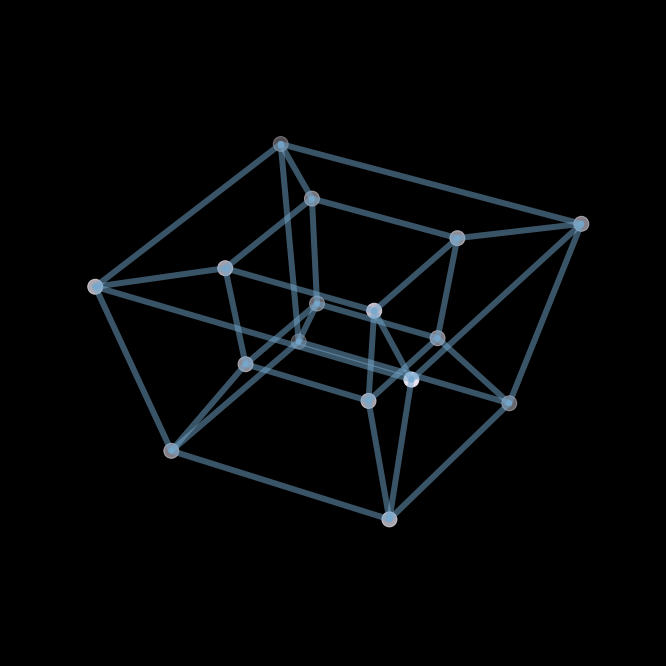

In [24]:
create_plot(v=vertices_norm, edges=edges, t=20, p=0, h=1.5)

### Create a rotating animation

In [124]:
def create_anim(v, edges, frames, p, h):

    for i in range(frames):
        t = 720/frames * i
        v_rot = rot_4d(v, t=t, p=p)
        v_proj = proj_4d(v_rot, h=h)
        
        index = (4-len(str(i)))*'0' + str(i)
        fname = './output/frame_{0}.png'.format(index)
        plot_4d(v=v_proj, edges=edges, fname=fname)

In [125]:
create_anim(v=vertices_norm, edges=edges, frames=360*6, p=3, h=1.5)